# Przemysław Kaleta
Data: https://data.stanford.edu/hcmst2017

In [180]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import xgboost as xgb

from collections import defaultdict

In [158]:
data = pd.read_stata("hcmts.dta")

Explanations of variable names taken from:

https://stacks.stanford.edu/file/druid:vt073cc9067/HCMST_2017_fresh_Codeboodk_v1.1a.pdf

* Yes/no questions:
    * **Q5** Is [Partner name] the same sex as you? 
    * **Q25_2** Did you and [Partner name] attend the same high school?
    * **Q10** Highest level of schooling of partner
    * **hcm2017q24_met_online** Met online
    
* Quantitative questions:
    * **w6_q9** partner age in 2017
    * **w6_q24_length** length of q24 how met answer in characters

In [159]:
binary_variables = ["Q5", "Q25_2", "Q26_2",  "hcm2017q24_met_online"]
continuous_variables = ["w6_q9", "w6_q24_length"]
predicted_variables = ["S1"]
variables = binary_variables + continuous_variables + predicted_variables
mydata = data.loc[data.S1.notna(), variables]

## Model

In [160]:
# Dictionary with keys as columns of categorical variables 
# and values as functions which for a given code tell us what category it is
name_from_code = defaultdict(lambda: lambda x: x)

# usage: name_from_code["column_name"](code)
# If column name is not in binary variables name_from_code["column_name"] is an identity function.

for column_name in binary_variables + predicted_variables:
    
    column = mydata[column_name].values
    
    def _name_from_code(x, col=column):
        return col.from_codes([x], col.categories)[0]
    
    name_from_code[column_name] = _name_from_code
    
    mydata[column_name] = column.codes
    


In [171]:
X, y = mydata.drop("S1", axis=1), mydata["S1"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.35,
                max_depth = 5, alpha = 0, n_estimators = 100)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
y_pred_train = xgb_model.predict(X_train)

def test_classifier(y_true, y_pred):
    n = len(y_true)
    print(f"Positive/negative percentages in population: {sum(y_true) / n} / {sum(y_true == 0) / n}")
    print(f"Accuracy {sum(y_true == y_pred) / n}")
    print(f"F1 score: {f1_score(y_true, y_pred)}")
    
test_classifier(y_test, y_pred)

colnames = X_train.columns
names_explained_list = ["same_sex", "high_school", "university", "met_online", "partner_age", "w6_q24_length"]
names_explained = {colname: colname_explained for colname, colname_explained in zip(colnames, names_explained_list)}

Positive/negative percentages in population: 0.405982905982906 / 0.594017094017094
Accuracy 0.8062678062678063
F1 score: 0.7246963562753035


In [172]:
# Filling unknown values with means
means = X_train.apply(lambda x: x.mean(), axis=0)
x_train = X_train.fillna(dict(means))
x_test = X_test.fillna(dict(means))
mydata = mydata.fillna(dict(means))

In [173]:
logreg_model = LogisticRegression(solver="liblinear")
logreg_model.fit(x_train, y_train)
y_pred = logreg_model.predict(x_test)
test_classifier(y_test, y_pred)

Positive/negative percentages in population: 0.405982905982906 / 0.594017094017094
Accuracy 0.7749287749287749
F1 score: 0.6594827586206897


# Wizualizacja reszt

## Rezydua vs odpowiedź modelu

In [47]:
def get_proba(model, person, columns=None):
    columns = columns or ['Q5', 'Q25_2', 'Q26_2', 'hcm2017q24_met_online', 'w6_q9','w6_q24_length']
    new_person = pd.DataFrame([person.values], columns=columns)
    return model.predict_proba(new_person)[0][0]

In [124]:
y = 1 - y_train
y_hat = x_train.apply(lambda x: get_proba(xgb_model, x), axis=1)

Text(0, 0.5, 'Residuals')

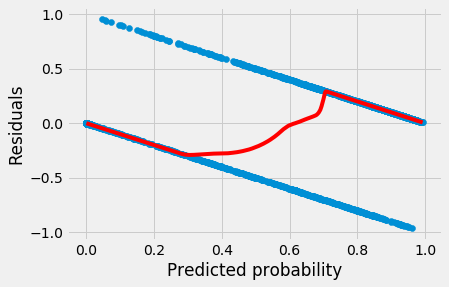

In [130]:
plt.style.use('fivethirtyeight')
plt.scatter(y_train_hat, y - y_hat)
lowess_points = lowess(y - y_hat, y_hat, is_sorted=False, frac=0.3)
x_lowess = lowess_points[:, 0]
y_lowess = lowess_points[:, 1]
plt.plot(x_lowess, y_lowess, color="red", label="loess trend curve")
plt.xlabel("Predicted probability")
plt.ylabel("Residuals")

Powyżej widzimy wykres odchyłek modelu w zależności od wartości predykcji prawdopodobieństwa. Idealnie by było, gdyby dla prawdopodobieństw `p` większych niż 0.5 rezydua wynosiły `1-p`, a dla mniejszych `-p`. Nie do końca tak jest, ale z tego niezbyt czytelnego wykresu możemy zauwazyć, że taki trend jest z grubsza widoczny - to dobrze.

## Rezydua vs zmienna

Text(0, 0.5, 'Residuals')

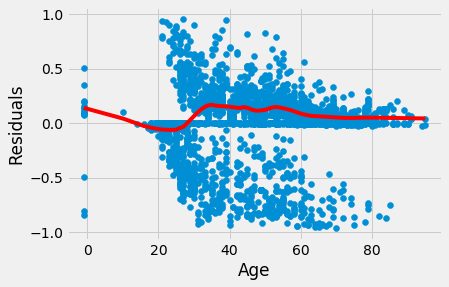

In [140]:
variable = x_train["w6_q9"]
plt.scatter(variable, y - y_hat)
lowess_points = lowess(y - y_hat, variable, is_sorted=False, frac=0.2)
x_lowess = lowess_points[:, 0]
y_lowess = lowess_points[:, 1]
plt.plot(x_lowess, y_lowess, color="red", label="loess trend curve")
plt.xlabel("Age")
plt.ylabel("Residuals")

Widzimy, że rezydua trochę wzrastają w okolicach zmiennej Age=30.

# Odległość Cooka

In [174]:
x_train = x_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

In [146]:
def get_model(x, y):
    xgb_model = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.35,
                max_depth = 5, alpha = 0, n_estimators = 100)
    xgb_model.fit(x, y)
    return xgb_model

In [185]:
xgb_model = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.35,
                max_depth = 5, alpha = 0, n_estimators = 100)

n = len(x_train)
cook_values = np.zeros(n)
assert(len(y_train) == n)
for i in tqdm(range(n)):
    x = x_train.drop(i)
    y = y_train.drop(i)
    xgb_model.fit(x, y)
    y_hat = xgb_model.predict(x)
    cook_values[i] = mean_squared_error(y, y_hat) 

100%|██████████| 2808/2808 [03:04<00:00, 15.69it/s]


Text(0, 0.5, "Cook's distance")

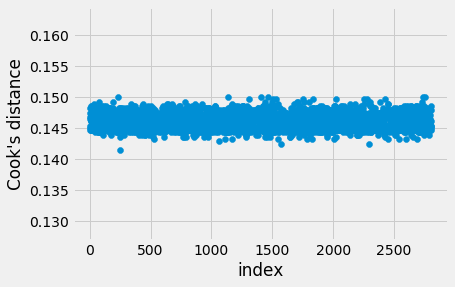

In [189]:
plt.scatter(list(range(n)), cook_values)
plt.xlabel("index")
plt.ylabel("Cook's distance")

Dzięki odległości Cooka możemy mierzyć jak bardzo poszczególna obserwacja wpływa na zachowanie modelu. Dzięki temu moglibyśmy ręcznie zbadać najbardziej wpływowe obserwacje (być może ich wpływ byłby spowodowany jakimiś błędami w danych). Wartości te nie są przeskalowane w żaden sposób, i-ta wartość odległości Cooka to po prostu błąd średniokwadratowy po wyrzuceniu pojedynczaej obserwacji. Uznałem, że najbardziej liczy sie porównanie wyników między obserwacjami, a nie sama wartość. Ponadto nie jestem pewien czy błąd średniokwadratowy w problemie klasyfikacji jest najlepsza metryką, ale z pewnością jest to jakaś miara działania modelu.